In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#import matplotlib
#print(matplotlib.matplotlib_fname())

def Popen(c,Ko_,Kc):
    """
    Kc: ligand dissociation constant when channel in closed state
    Ko_: effective open-state dissociation constant : Ko_ = Ko exp(beta epsilon/5)
    c: ligand concentration
    """
    return (c/Ko_)**5/((c/Ko_)**5+(1+c/Kc)**5)

def Regularized(dose,resp,thresh=3):
    """
    response: experimental current response
    thresh: threshold below which the current is considered as too small.
    regularize the response curve by removing the NaNs, and renormalize it between 0 and 1 if there are enough points and the maximum is sufficiently high.
    """
    # sanitize
    msk = (~np.isnan(dose)) & (~np.isnan(resp)) & (dose > 0)

    dose, resp = dose[msk], resp[msk]
    
    if dose.size < 4:
        return None
    if np.max(resp)>=thresh:
        return (resp - np.min(resp))/(np.max(resp) - np.min(resp))
    else:
        return None
def sem(a, axis=0):
    """
    standard error mean computation
    """
    a = np.asarray(a, dtype=float)
    n = np.sum(~np.isnan(a), axis=axis)
    return np.nanstd(a, axis=axis, ddof=0) / np.sqrt(np.maximum(n, 1))

In [26]:
# --------------------------- import ---------------------------
# CONFIG
directory = "/mnt/hcleroy/PostDoc2/octopus_smelling/experimental_data"
xlsx = "doseHeteromer_dataAll.xlsx"
sheets = {"CR518": "CR518", "CR518_918": "CR518-918", "CR918": "CR918", "GCaMP": "GCaMP"}
ligandList = [
    "Medroxyprogesterone", "Androsterone", "Progesterone", "Estrone", "Chloroquine",
    "Strychnine", "Naringin", "Nootkatone", "Costunolide", "Taurocholic acid", "Norharmane"
]
maxDose_CR518     = np.array([9,11,11,11,11,10,11, 9, 8,11,11], dtype=int)
maxDose_CR518_918 = np.array([9,11,11,11,11,10,11,11,11,10,11], dtype=int)
maxDose_CR918     = np.array([9,11,11,11,11,10,11,11,11,10,11], dtype=int)
respThresh = 3.0

# IO
df_518     = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR518"], engine="openpyxl")
df_518_918 = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR518_918"], engine="openpyxl")
df_918     = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["CR918"], engine="openpyxl")
df_gc      = pd.read_excel(f"{directory}/{xlsx}", sheet_name=sheets["GCaMP"], engine="openpyxl")

# transform the pandas datafram into numpy array, with index matching ligand names:
def idx_list(df):
    out = []
    col_lig = "Var2" if "Var2" in df.columns else df.columns[1]
    for lig in ligandList:
        idx = df.index[df[col_lig] == lig].to_numpy()
        out.append(idx)
    return out

idx_518     = idx_list(df_518)
idx_518_918 = idx_list(df_518_918)
idx_918     = idx_list(df_918)
idx_gc      = idx_list(df_gc)

# Collect replicate matrices per ligand (rows: doses; cols: cells/replicates)
def grab_vals(df, idxs):
    # columns 4:end in MATLAB -> pandas iloc[:, 3:]
    return [df.iloc[idx, 3:].to_numpy(dtype=float) for idx in idxs]

CR518_all     = grab_vals(df_518, idx_518)
CR518_918_all = grab_vals(df_518_918, idx_518_918)
CR918_all     = grab_vals(df_918, idx_918)
GCaMP_all     = grab_vals(df_gc, idx_gc)

# grab the dose responses
dose_518 = df_518.iloc[idx_518[0], 2].to_numpy(dtype=float)
dose_918 = df_918.iloc[idx_918[0], 2].to_numpy(dtype=float)
dose_518_918 = df_518.iloc[idx_518_918[0], 2].to_numpy(dtype=float)
dose_gc = df_gc.iloc[idx_gc[0], 2].to_numpy(dtype=float)

# regularize
NCR518_all,NCR518_918_all,NCR918_all,NGCaMP_all = list(),list(),list(),list()
for i in range(ligandList.__len__()):
    NCR518,NCR518_918,NCR918,NGCaMP = list(),list(),list(),list()
    for j in range(CR518_all[i].shape[1]):
        if Regularized(dose_518,CR518_all[i][:,j]) is not None:
            #NCR518.append(Regularized(dose_518,CR518_all[i][:,j]))
            NCR518.append(CR518_all[i][:,j])

    for j in range(CR918_all[i].shape[1]):
        if Regularized(dose_918,CR918_all[i][:,j]) is not None:
            #NCR918.append(Regularized(dose_918,CR918_all[i][:,j]))
            NCR918.append(CR918_all[i][:,j])

    for j in range(CR518_918_all[i].shape[1]):
        if Regularized(dose_518_918,CR518_918_all[i][:,j]) is not None:
            #NCR518_918.append(Regularized(dose_518_918,CR518_918_all[i][:,j]))
            NCR518_918.append(CR518_918_all[i][:,j])

    for j in range(GCaMP_all[i].shape[1]):
        if Regularized(dose_gc,GCaMP_all[i][:,j]) is not None:
            #NGCaMP.append(Regularized(dose_gc,GCaMP_all[i][:,j]))
            NGCaMP.append(GCaMP_all[i][:,j])
    NCR518_all.append(np.array(NCR518))
    NCR918_all.append(np.array(NCR918))
    NCR518_918_all.append(np.array(NCR518_918))
    NGCaMP_all.append(np.array(NGCaMP))

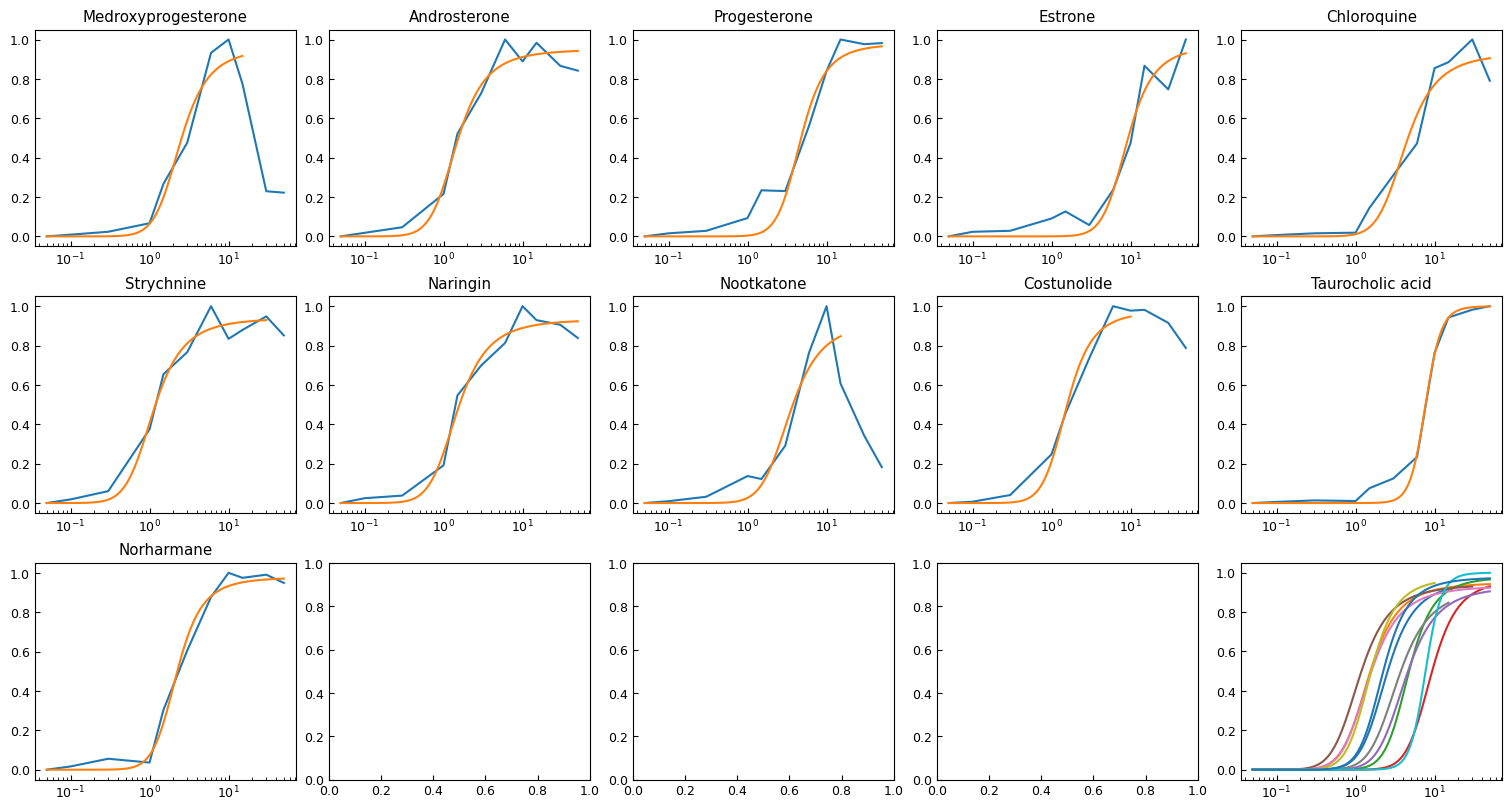

In [27]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()
popts518 = list()

for i, lig in enumerate(ligandList):
    ax = axes[i]
    # Mean curve
    mu_518     = np.mean(NCR518_all[i], axis=0)
    mu_518 = Regularized(dose_518,mu_518)
    # Error bars

    #se_518     = sem(Regularized(dose_518,NCR518_all[i]), axis=0)
    #for NCR518 in NCR518_all[i]:
    #    ax.plot(dose_518[:-1],NCR518[:-1],color='grey',alpha=0.7)
    ax.plot(dose_518[:-1],mu_518)
        
    k = maxDose_CR518[i]
    #ax.errorbar(dose_518[:k], mu_518[:k], yerr=se_518[:k], fmt='o', ms=5, mfc='b', mec='k', ls='none')

    popt,pcov = curve_fit(Popen,dose_518[:k],mu_518[:k])
    popts518.append(popt)
    X = np.logspace(np.log(np.min(dose_518[:k]))/np.log(10),np.log(np.max(dose_518[:k]))/np.log(10),100)
    ax.plot(X,Popen(X,*popt))    
    axes[-1].plot(X,Popen(X,*popt))

    ax.set_xscale("log")
    ax.set_title(lig)

axes[-1].set_xscale('log')
popts518=np.array(popts518)


In [28]:
popts518

array([[ 1.1696295 ,  2.16020793],
       [ 0.67832264,  1.21128596],
       [ 2.55985648,  5.53398378],
       [ 4.63254161,  9.21434745],
       [ 1.84415305,  3.07274076],
       [ 0.49776715,  0.85656067],
       [ 0.64440945,  1.08333344],
       [ 1.44750841,  2.36009925],
       [ 0.82264365,  1.71735874],
       [ 6.71925377, 53.20897674],
       [ 1.18525319,  2.51118961]])

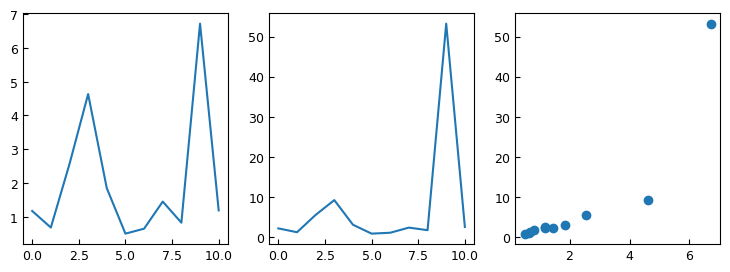

In [29]:
fig,ax = plt.subplots(ncols=3,figsize=(9,3))
ax[0].plot(np.arange(0,popts518.__len__(),1),popts518[:,0])
ax[1].plot(np.arange(0,popts518.__len__(),1),popts518[:,1])
ax[2].scatter(popts518[:,0],popts518[:,1])

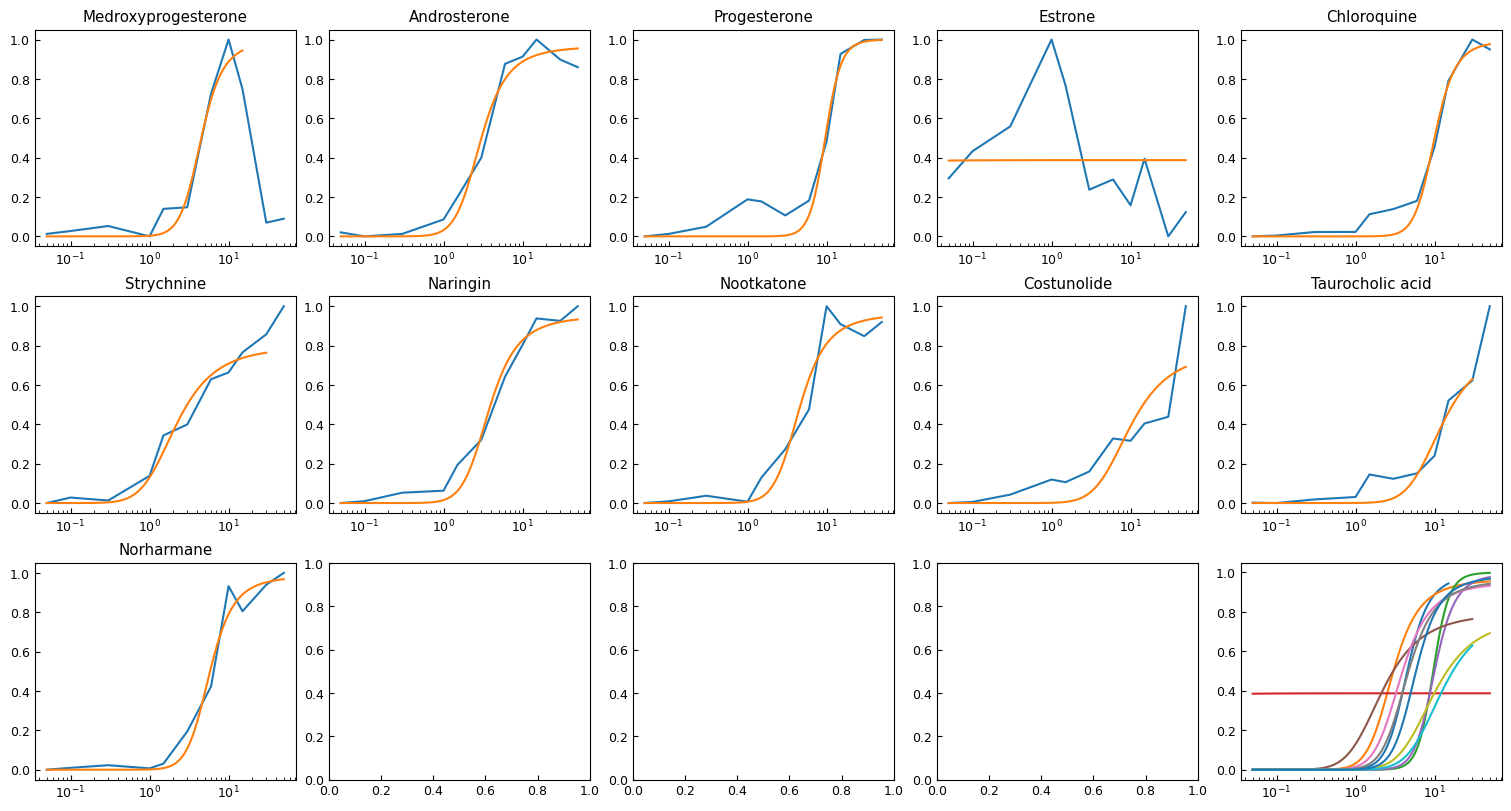

In [30]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()
popts518_918 = list()

for i, lig in enumerate(ligandList):
    ax = axes[i]
    # Mean curve
    mu518_918     = np.mean(NCR518_918_all[i], axis=0)
    mu518_918 = Regularized(dose_518_918,mu518_918)
    # Error bars

    #se_518     = sem(Regularized(dose_518,NCR518_all[i]), axis=0)
    #for NCR518 in NCR518_all[i]:
    #    ax.plot(dose_518[:-1],NCR518[:-1],color='grey',alpha=0.7)
    ax.plot(dose_518_918[:-1],mu518_918)
        
    k = maxDose_CR518_918[i]
    #ax.errorbar(dose_518[:k], mu_518[:k], yerr=se_518[:k], fmt='o', ms=5, mfc='b', mec='k', ls='none')

    popt,pcov = curve_fit(Popen,dose_518_918[:k],mu518_918[:k])
    popts518_918.append(popt)
    X = np.logspace(np.log(np.min(dose_518_918[:k]))/np.log(10),np.log(np.max(dose_518_918[:k]))/np.log(10),100)
    ax.plot(X,Popen(X,*popt))    
    axes[-1].plot(X,Popen(X,*popt))

    ax.set_xscale("log")
    ax.set_title(lig)

axes[-1].set_xscale('log')
popts518_918=np.array(popts518_918)


In [31]:
print(popts518_918)

[[2.79467774e+00 7.31409113e+00]
 [1.46361167e+00 2.84187817e+00]
 [8.40215904e+00 6.59734698e+01]
 [1.04110684e-04 9.49834688e-05]
 [6.56504246e+00 1.90866043e+01]
 [6.95234633e-01 9.05414004e-01]
 [1.75164416e+00 3.14957939e+00]
 [2.21843139e+00 4.20443955e+00]
 [3.03426554e+00 3.84108559e+00]
 [3.97653123e+00 5.18465747e+00]
 [3.25710877e+00 7.37784474e+00]]


(0.0, 20.0)

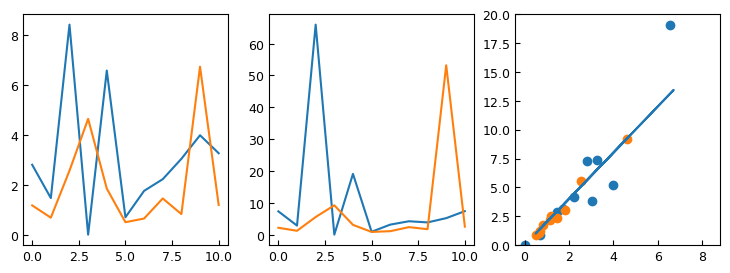

In [32]:
fig,ax = plt.subplots(ncols=3,figsize=(9,3))
ax[0].plot(np.arange(0,popts518_918.__len__(),1),popts518_918[:,0])
ax[1].plot(np.arange(0,popts518_918.__len__(),1),popts518_918[:,1])
ax[2].scatter(popts518_918[:,0],popts518_918[:,1])

ax[0].plot(np.arange(0,popts518.__len__(),1),popts518[:,0])
ax[1].plot(np.arange(0,popts518.__len__(),1),popts518[:,1])
ax[2].scatter(popts518[:,0],popts518[:,1])

ax[2].plot(popts518[:,0],2*popts518[:,0])
ax[2].set_ylim(0,20)

In [33]:
print(popts518_918)

[[2.79467774e+00 7.31409113e+00]
 [1.46361167e+00 2.84187817e+00]
 [8.40215904e+00 6.59734698e+01]
 [1.04110684e-04 9.49834688e-05]
 [6.56504246e+00 1.90866043e+01]
 [6.95234633e-01 9.05414004e-01]
 [1.75164416e+00 3.14957939e+00]
 [2.21843139e+00 4.20443955e+00]
 [3.03426554e+00 3.84108559e+00]
 [3.97653123e+00 5.18465747e+00]
 [3.25710877e+00 7.37784474e+00]]


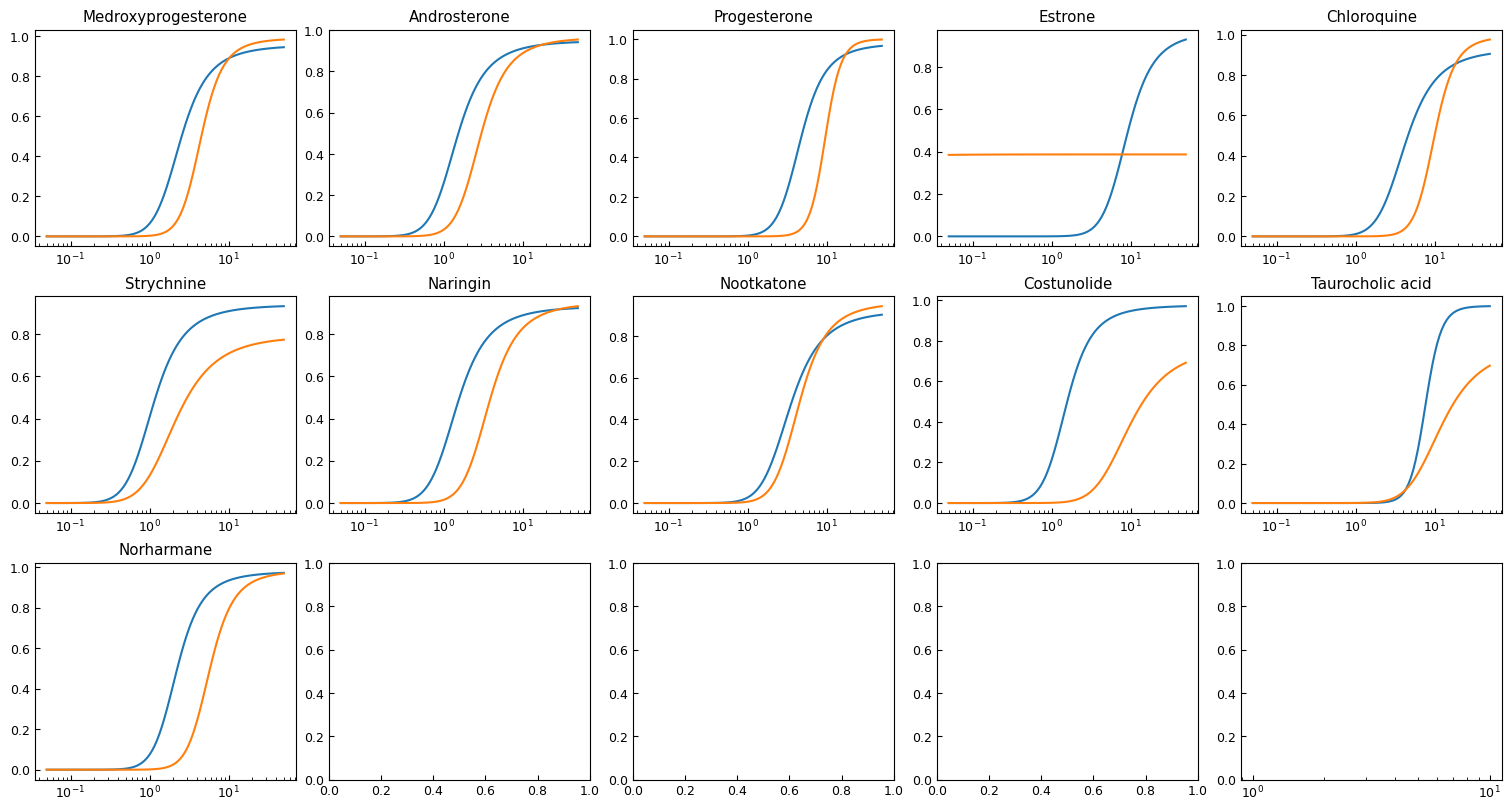

In [34]:
# ---------- plotting grid ----------
nLig = len(ligandList)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), constrained_layout=True)
axes = axes.ravel()

for i, lig in enumerate(ligandList):
    ax = axes[i]
    
    X = np.logspace(np.log(np.min(dose_518[:k]))/np.log(10),np.log(np.max(dose_518[:k]))/np.log(10),100)
    ax.plot(X,Popen(X,*popts518[i]))
    X = np.logspace(np.log(np.min(dose_518_918[:k]))/np.log(10),np.log(np.max(dose_518_918[:k]))/np.log(10),100)
    ax.plot(X,Popen(X,*popts518_918[i]))

    ax.set_xscale("log")
    ax.set_title(lig)

axes[-1].set_xscale('log')
popts518_918=np.array(popts518_918)
